In [59]:
import numpy as np
import os
import multiprocessing as mp
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
import hdbscan 
from sklearn.cluster import HDBSCAN
from hdbscan import validity
import matplotlib.pyplot as plt
from shutil import copyfile 

In [60]:
protein_pdb = "/mnt/nas1/lanwei-125/PRLR/PRLR.pdb"
peptide_pdb_dir = '/mnt/nas1/lanwei-125/PRLR/HPEP/hpep-result/'
point_plot = f'{peptide_pdb_dir}/cluster_point_plot.png'
cluster_result = f'{peptide_pdb_dir}/cluster_result.txt'

In [61]:
protein_coords = []
with open(protein_pdb) as f:
    for line in f:
        if line.startswith('ATOM'):
            x = float(line[30:38]) 
            y = float(line[38:46])
            z = float(line[46:54]) 
            protein_coords.append([x, y, z])
print(len(protein_coords))

1684


In [62]:
peptide_coords = []
peptide_names = []
for pdb in os.listdir(peptide_pdb_dir):
    if pdb.endswith('.pdb'):
        coords = []
        with open(os.path.join(peptide_pdb_dir, pdb)) as f:
            for line in f:
                if line.startswith('ATOM'):
                    x = float(line[30:38])
                    y = float(line[38:46]) 
                    z = float(line[46:54])
                    coords.append([x, y, z])
        peptide_coords.append(coords)
        peptide_names.append(pdb.split('.')[0])
print(len(peptide_coords))

1129


In [63]:
def calc_contacts(peptide_idx, peptide_coords, protein_coords):
    dists = [0] * len(protein_coords)
    for p_idx, p_coord in enumerate(protein_coords):
        contact = 0
        for pe_coord in peptide_coords[peptide_idx]:
            dist = np.linalg.norm(np.array(p_coord) - np.array(pe_coord))  
            if dist < 7:
                contact += 1
                #break
        
        dists[p_idx] = contact
        
    return dists

contact_matrices = []

with mp.Pool() as pool:
    results = [pool.apply_async(calc_contacts, args=(i, peptide_coords, protein_coords)) 
            for i in range(len(peptide_coords))]
    contact_matrices = [r.get() for r in results]
print(len(contact_matrices))

1129


In [64]:

contact_matrixs = []
for dists in contact_matrices:
    contact_matrixs.append(dists)
contact_matrixs = np.array(contact_matrixs)


100%|██████████| 90/90 [00:20<00:00,  4.43it/s]


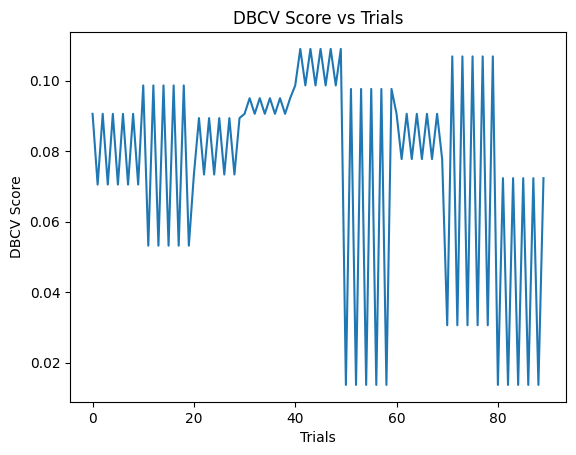

Best Model: HDBSCAN(cluster_selection_epsilon=0.1, cluster_selection_method='leaf',
        core_dist_n_jobs=-1, gen_min_span_tree=True, min_cluster_size=3,
        min_samples=3), Score: 0.10897198158323804


In [65]:
scores = {}

def run_hdbscan(params):
    min_cluster_size, min_samples, eps, cluster_selection_method = params
    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          min_samples=min_samples,
                          cluster_selection_epsilon=eps,
                          cluster_selection_method=cluster_selection_method, 
                          gen_min_span_tree=True,
                          core_dist_n_jobs=-1
                          ).fit(contact_matrixs)
    score = hdb.relative_validity_
    return hdb, score

# Define the parameter ranges
min_cluster_sizes = list(range(2, 5))
min_samples_values = list(range(2, 5))
eps_values = [x * 0.1 for x in range(1, 10, 2)]
cluster_selection_methods = ['eom', 'leaf']

# Generate all combinations of parameters
param_combinations = [(min_cluster_size, min_samples, eps, cluster_selection_method)
                      for min_cluster_size in min_cluster_sizes
                      for min_samples in min_samples_values
                      for eps in eps_values
                      for cluster_selection_method in cluster_selection_methods]

# Run in parallel and track progress with tqdm
results = Parallel(n_jobs=-1)(delayed(run_hdbscan)(params) for params in tqdm(param_combinations))

# Store results in the scores dictionary
for hdb, score in results:
    scores[hdb] = score

# Plotting
plt.plot(list(range(len(scores))), scores.values())
plt.xlabel('Trials') 
plt.ylabel('DBCV Score')
plt.title('DBCV Score vs Trials')
plt.show()

# Get the best model based on the maximum score
best_model = max(scores, key=scores.get)
print(f"Best Model: {best_model}, Score: {scores[best_model]}")

In [98]:
hdb =  hdbscan.HDBSCAN(
        cluster_selection_epsilon=0.1, 
        cluster_selection_method='eom',
        core_dist_n_jobs=-1, 
        gen_min_span_tree=True, 
        min_cluster_size=2,
        min_samples=10
        ).fit(contact_matrixs)
score = hdb.relative_validity_
labels = hdb.labels_
print(score)
labels

0.012171154352312367


array([ 2,  2,  3, ..., -1,  2,  0])

In [97]:
cluster_keys = {}
for label in set(labels):
    cluster_keys[label] = []
for i, label in enumerate(labels):
    cluster_keys[label].append(peptide_names[i])
final_label = []
for label in sorted(cluster_keys):
        print(f'Cluster {label}:{cluster_keys[label]}\n {len(cluster_keys[label])}')

Cluster -1:['LHYHNIT', 'SILRSWNEPL', 'QQMNQKDFLS', 'AVLHYHNITI', 'LLHCLRRDS', 'IHNLSSEMFS', 'KENEIYPVWS', 'QMADEESRLS', 'LKCRIIHNNN', 'LIVSILRSW', 'KENEIYPVW', 'GRGFITKAIN', 'GMELIVSQV', 'IDNYLKLLKC', 'HCLRRD', 'QREGLHRRH', 'DKRYTHG', 'EIYPVWS', 'LLHCLRR', 'DSHKIDNY', 'EEQTKRLLEG', 'DLRAVLHYHN', 'EQREGLHRRH', 'VVLSHYIHN', 'QMNQKDF', 'IYPVWSGLP', 'ILRSWNEPLY', 'SWNEPLYH', 'WNEPLYHL', 'YYNLLHCLRR', 'MELIVSQVHP', 'VWSGLP', 'QTKRLLEG', 'WSGLPSLQ', 'SGLPSLQMA', 'WSGLPSLQMA', 'SRLSAYYNLL', 'YPVWSGLP', 'LRAVLHYHN', 'VLHYHNITI', 'SEFDKRYTH', 'RYTHGRGFI', 'RRDSHKIDN', 'KLLKCRIIHN', 'PAQVDLRAVL', 'NEPLYHLVT', 'NYLKLLKCRI']
 47
Cluster 0:['PEDKEQEQR', 'IVSILR', 'CQVTLR', 'CLRRDSH', 'QAQQMNQ', 'YIHNLS', 'KEQAQQ', 'EQAQQMN', 'QVHPETK', 'QEQREGL', 'DLRAVL']
 11
Cluster 1:['REGLHRR', 'TKRLLEGM', 'KRLLEGM', 'LKCRIIH', 'EQTKRLLE', 'EQAQQMNQK', 'HLVTEVRG', 'DKEQEQREGL', 'IEEQTKRLLE', 'TKRLLEGMEL', 'GAARCQ', 'QEQREG', 'REGLHRRHK', 'RGMQEA', 'KEQAQQMN', 'FLSLIVSILR', 'AARCQVT', 'EQEQREGLHR', 'QEQREGLHRR',

In [92]:
len(cluster_keys)

6

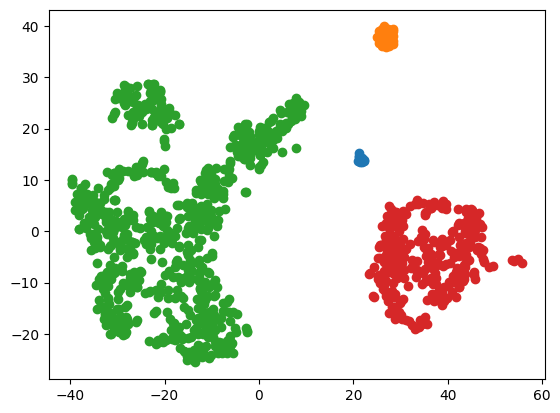

In [93]:
tsne = TSNE()
X_tsne = tsne.fit_transform(contact_matrixs)

# 2D散点图
fig, ax = plt.subplots()

for i in range(4):
    ax.scatter(X_tsne[labels==i, 0], 
            X_tsne[labels==i, 1], 
            )
#ax.legend()
plt.show()

In [ ]:
cluster = '/mnt/nas1/lanwei-125/PRLR/HPEP/cluster/'

min_scores = {}
for label, peptides in cluster_keys.items():
    min_score = float('inf')
    min_peptide = None
    for peptide in peptides:
        pdb_file = os.path.join(peptide_pdb_dir, peptide + '.pdb')
        with open(pdb_file) as f:
            for line in f:
                if line.startswith('REMARK ITScore'):
                    score = float(line.split()[-1])
                    if score < min_score:
                        min_score = score
                        min_peptide = peptide
    min_scores[label] = (min_peptide, min_score)

dir_list =[]
for label, (peptide, score) in min_scores.items():
    cluster_dir = os.path.join(cluster_path,'cluster_{}'.format(label))
    dir_list.append(cluster_dir)
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir, exist_ok=True)
    src_pdb = os.path.join(peptide_pdb_dir, peptide + '.pdb')
    dst_pdb = os.path.join(cluster_dir, peptide + '.pdb')
    if not os.path.exists(dst_pdb):
        copyfile(src_pdb, dst_pdb)


In [ ]:
cluster = '/mnt/nas1/lanwei-125/PRLR/HPEP/cluster/'

cluster_labels_pdb = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_labels_pdb.append(cluster_keys[cluster_labels_keys])

a = 0

for cluster_label_pdb in cluster_labels_pdb:
    print(cluster_label_pdb)
    i = 0
    a = a + 1
  # 定义输出pdb文件名
    out_file = os.path.join(cluster, f'{a}.pdb' )
    
    for pdb in cluster_label_pdb:
       
        pdb_file = os.path.join(peptide_pdb_dir, pdb + '.pdb')
        with open(out_file, 'a') as f_out:
            with open(pdb_file) as f_in:
              i = i + 1
              f_out.write(f'\nMODEL {i}\n')
              
              # 过滤掉MODEL/END/ENDMDL行
              lines = [line for line in f_in if 'MODEL' not in line 
                        and 'END' not in line and 'ENDMDL' not in line]  

              f_out.write(''.join(lines))

              f_out.write(f_in.read())
              f_out.write('END\n')
              f_out.write('ENDMDL\n\n')